In [1]:
from lbmpy.session import *

from pystencils.sympyextensions import prod
from lbmpy.stencils import get_stencil
from lbmpy.moments import get_default_moment_set_for_stencil, moments_up_to_order
from lbmpy.creationfunctions import create_lb_method, create_generic_mrt
from lbmpy.quadratic_equilibrium_construction import *
from lbmpy.chapman_enskog import ChapmanEnskogAnalysis
from lbmpy.moments import exponent_to_polynomial_representation

# Demo: Theoretical Background - LB Equilibrium Construction using quadratic Ansatz

According to book by Wolf-Gladrow _"Lattice-Gas Cellular Automata and Lattice Boltzmann Methods"_ (2005)

Through the Chapman Enskog analysis the following necessary conditions can be found in order for a lattice Boltzmann Method to approximate the Navier Stokes mass and momentum conservation equations. In the Chapman Enskog analysis only the moments of the equilibrium distribution functions are used, thus all conditions are formulated with regard to the moments $\Pi$ of the equilibrium distribution function $f^{(eq)}$

The conditions are:
- zeroth moment is the density: $\Pi_0 = \sum_q f^{(eq)}_q = \rho$
- first moment is the momentum density, or for incompressible models the velocity:
    - compressible: $\Pi_\alpha = \sum_q c_{q\alpha} f^{(eq)}_q = \rho u_\alpha$
    - incompressible: $\Pi_\alpha = \sum_q c_{q\alpha} f^{(eq)}_q = u_\alpha$
- second moment is related to the pressure tensor and has to be: 
   $\Pi_{\alpha\beta} = \sum_q c_{q\alpha} c_{q\beta} f^{(eq)}_q =  \rho u_\alpha u_\beta + p \delta_{\alpha\beta}$
- third order moments are also used in the Chapman Enskog expansion. The conditions on these moments are harder to formulate and are investigated later. A commonly used, but overly restrictive choice is 
  $\Pi_{\alpha\beta\gamma} = p ( \delta_{\alpha\beta} u_\gamma + \delta_{\alpha\gamma} u_\beta + \delta_{\beta\gamma} u_\alpha )$. In Wolf-Gladrows book these conditions on the third order moment are not used but implicitly fulfilled by choosing fixed fractions of the coefficients $\frac{A_1}{A_2}$ etc.

Now the following generic quadratic ansatz is used for the equilibrium distribution. 

$$f^{(eq)}_q = A_{|q|} + B_{|q|} (\mathbf{c}_q \cdot \mathbf{u}^2 ) + D_{|q|} \mathbf{u}^2$$


The free parameters $A_{|q|}, B_{|q|}, C_{|q|}$ and $D_{|q|}$ are chosen such that above conditions are fulfilled.
The subscript $|q|$ is an integer and defined as the sum of the absolute values of the corresponding stencil direction. For example: for center $|q|=0$, for direct neighbors like north, east, top $|q|=1$ for 2D diagonals like north-west its 2 and for 3D diagnoals like bottom-north-west its 3.

_lbmpy_ can create this quadratic ansatz for use for a given stencil:

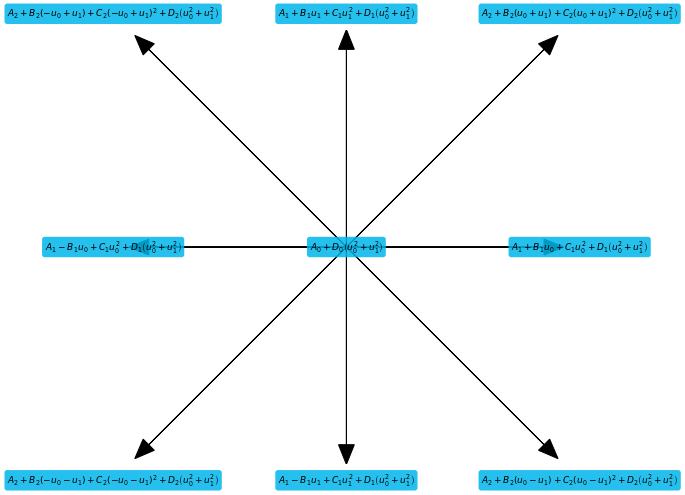

In [2]:
# Create Stencil
stencil_name = "D2Q9"
stencil = get_stencil(stencil_name)

# Create quadratic equilibrium ansatz
ansatz = generic_equilibrium_ansatz(stencil)

# Show equilibrium for each stencil direction
plt.figure(figsize=(12,8))
ps.stencil.plot(stencil, data=ansatz, textsize=9, slice=True)

Next we define the restrictions obtained through the Chapman Enskog analysis, in the book listed as equations (5.4.2) and following:

In [3]:
moment_restrictions = hydrodynamic_moment_values(dim=len(stencil[0]), compressible=True, up_to_order=2)
moment_restrictions

The parameter `up_to_order` can be modified to 3. Then the third order restrictions are included as well (see discussion above). Using these moment restrictions, the necessary conditions on the parameter $A$ to $D$ can be found.

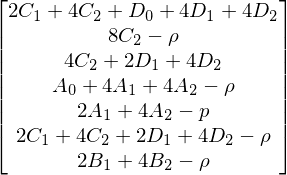

In [4]:
equations = moment_constraint_equations(stencil, ansatz, moment_restrictions)
sp.Matrix(equations)

Since we have still more unknowns than equations, some additional restrictions have to be imposed.

In [5]:
dofs = generic_equilibrium_ansatz_parameters(stencil)
dofs

In Wolf-Gladrows book the following arbitrary restrictions are added to the necessary constraints:

$$ \frac{A_0}{A_1} =  \frac{A_1}{A_2}  =  \frac{B_1}{B_2} =  \frac{D_0}{D_1} =: r$$

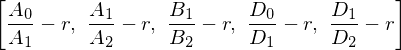

In [6]:
additional_restrictions = [
    "A_0 / A_1 - r",
    "A_1 / A_2 - r",
    "B_1 / B_2 - r",
    "D_0 / D_1 - r",
    "D_1 / D_2 - r", # comment out this line to get solution dependent on r
]
additional_restrictions = [sp.sympify(e) for e in additional_restrictions]
additional_restrictions

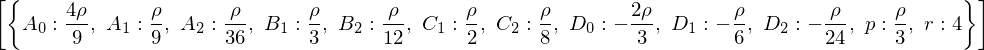

In [7]:
solveResult = sp.solve(equations + additional_restrictions, dofs + [sp.Symbol("r")], dict=True)
solveResult

The equilibrium we found here is the same as obtained with the usual _lbmpy_ construction technique:

In [8]:
constructed_equilibrium = sp.Matrix(ansatz).subs(solveResult[0]).expand()
normal_lbmpy_equilibrium = create_lb_method(stencil=stencil_name, compressible=True).get_equilibrium_terms()
assert constructed_equilibrium == normal_lbmpy_equilibrium

## Generalization of above technique


In [9]:
def generic_polynomial(u, coeff_prefix, order=2):
    dim = len(u)
    result = 0
    for idx in moments_up_to_order(order, dim=dim):
        u_prod = prod(u[i] ** exp for i, exp in enumerate(idx))
        coeff = sp.Symbol(("%s_" + ("%d" * dim)) % ((coeff_prefix,) + idx))
        result += coeff * u_prod
    return result


def generic_polynomial_coeffs(dim, coeff_prefix, order=2):
    result = []
    for idx in moments_up_to_order(order, dim=dim):
        result.append(sp.Symbol(("%s_" + ("%d" * dim)) % ((coeff_prefix,) + idx)))
    return result

In [10]:
allMoments = get_default_moment_set_for_stencil(stencil)
allMoments

We use, as before, all constraints for moments up order 2. This time we do not use a quadratic ansatz for the equilibrium distribution or the additional constraints (i.e. the ratios of coefficients being some constant $r$).
Instead an arbitrary second order polynomial $u$ is used for the third order moments. The forth order moment does not appear at all in the Chapman Enskog expansion and is thus set to a constant.

So we end up with the following moments

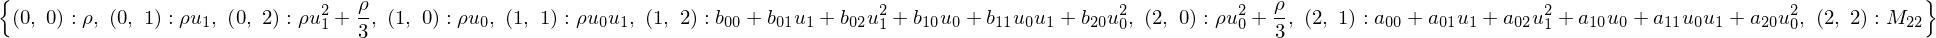

In [11]:
dim = len(stencil[0])
u = sp.symbols("u_:3")[:len(stencil[0])]
moment_restrictions = hydrodynamic_moment_values(dim=len(stencil[0]), compressible=True, up_to_order=2)
moment_restrictions[(2, 1)] = generic_polynomial(u, "a")
moment_restrictions[(1, 2)] = generic_polynomial(u, "b")
moment_restrictions[(2, 2)] = sp.Symbol("M_22")
moment_restrictions = {m: v.subs(sp.Symbol("p"), sp.Symbol("rho") / 3) for m, v in moment_restrictions.items()}
moment_restrictions

Next all parameters are collected..

In [12]:
parameters = generic_polynomial_coeffs(dim, "a") + generic_polynomial_coeffs(dim, "b") + [sp.Symbol("p")]
parameters

... and a _lbmpy_ LB method is created. On this method an automatic Chapman Enskog analysis can be conducted to find 
constraints for the free parameters above.

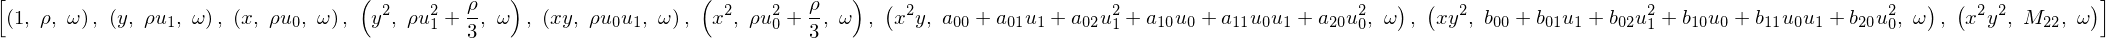

In [13]:
rr = sp.symbols("omega")
collision_table = [( exponent_to_polynomial_representation(m), v, rr) for m, v in  moment_restrictions.items()]
collision_table

In [14]:
method = create_generic_mrt(stencil, collision_table, compressible=True)
analysis = ChapmanEnskogAnalysis(method, constants=set(parameters))

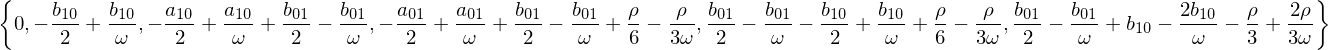

In [15]:
analysis.does_approximate_navier_stokes()

These constraints can be solved for the free parameters:

In [16]:
solveRes = sp.solve(analysis.does_approximate_navier_stokes(), parameters)
solveRes

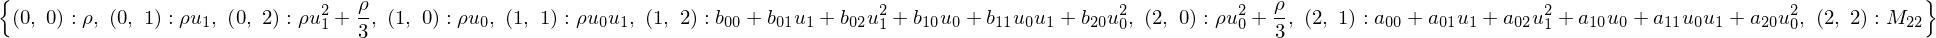

In [17]:
new_moment_restrictions = {a : b.subs(solveRes) for a, b in moment_restrictions.items()}
new_moment_restrictions

All methods constructed with these constraints should theoretically approximate Navier Stokes. 